In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

NUM_CLASSES = 3
CHANNELS_D = 3
IMG_SIZE = 256
DATA_DIR = "/home/will/Documents/datasets/archive/caltech101_classification/"

device = "cuda" if torch.cuda.is_available() else "cpu"
classes = ["Motorcycle", "Airplane", "Schooner"]

### **Data**

Normalizing the image data reduces the chance of vanishing & exploding gradients for the optimizer during training. To do this, calculate the mean and standard deviation of each channel for every image in the dataset, then subtract each value by its respective mean and divide by its standard deviation.

$$
Z = \dfrac{x - \mu}{\sigma}
$$

In [2]:
# for simplicity, just normalize whole dataset instead of each class label
def norm_transforms():
    transform = transforms.Compose(
        [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
    )
    dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unnorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unnorm
norm, unnorm = norm_transforms()

Since the number of images for schooner class is dramatically smaller than the other two classes in the dataset, I computed some weights to apply for the loss criterion during training by taking the difference of each portion by 1.

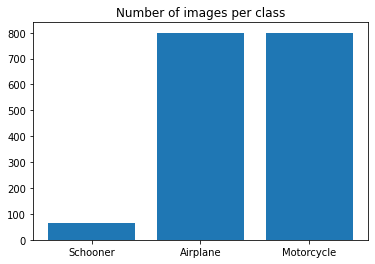

Class weights


0.962      Schooner
0.518      Airplane
0.520    Motorcycle
dtype: object

In [ ]:
import pandas as pd

class_weights = []
total_len = 0
for _, _, files in os.walk(DATA_DIR):
    if len(files) > 0:
        class_weights.append(len(files))
    total_len += len(files)
plt.bar(classes[::-1], class_weights)
plt.title("Number of images per class")
plt.show()

class_weights = np.round((1 - np.array(class_weights) / total_len), 3)
class_weights = class_weights.tolist()

print("Class weights")
df = pd.Series(classes[::-1], class_weights)
class_weights = torch.tensor(class_weights)

df

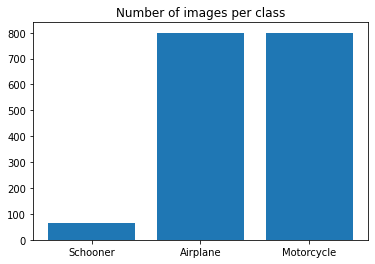

Class weights


0.962      Schooner
0.518      Airplane
0.520    Motorcycle
dtype: object

In [3]:
import pandas as pd

class_weights = []
total_len = 0
for _, _, files in os.walk(DATA_DIR):
    if len(files) > 0:
        class_weights.append(len(files))
    total_len += len(files)
plt.bar(classes[::-1], class_weights)
plt.title("Number of images per class")
plt.show()

class_weights = np.round((1 - np.array(class_weights) / total_len), 3)
class_weights = class_weights.tolist()

print("Class weights")
df = pd.Series(classes[::-1], class_weights)
class_weights = torch.tensor(class_weights)

df

The next step is to apply the transformations (Resizing each image to the same size and normalizing) and split the dataset. I originally planned on doing **60/20/20** split for a train, validation, and test set. However, I found that a **20/20** split would be too small and since I was testing a variety of different networks in one go, I wouldn't need to do much tuning. Ultimately, I decided on a **60/40** split and commented out the former.


In [4]:
def load_data():
    transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size

    train_data, test_data = torch.utils.data.random_split(
        dataset, [train_size, test_size]
    )

    return train_data, test_data
    # train_data, test_val_data = torch.utils.data.random_split(
    #     dataset, [train_size, test_val_size]
    # )

    # val_size = int(0.5 * len(test_val_data))
    # test_size = len(test_val_data) - val_size
    # val_data, test_data = torch.utils.data.random_split(
    #     test_val_data, [val_size, test_size]
    # )
    # return train_data, val_data, test_data
    
# train_data, val_data, test_data = load_data()
train_data, val_data = load_data()

### **My attempt at CNNs**

In [5]:
class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.fcl, self.net = self._gen_layers(num_layers, expansion)
        self.classifier = self._classifier()
        
    def _gen_layers(self, num_layers, expansion):
        layers = []
        in_channels = CHANNELS_D
        
        for i in range(num_layers):
            out_channels = expansion(in_channels)
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
            ]
            layers += [nn.ReLU(), nn.BatchNorm2d(out_channels)]
            layers += [nn.MaxPool2d(2, 2)]
            in_channels = out_channels
        fcl = ((IMG_SIZE // (2 ** num_layers)) ** 2) * in_channels
        
        return fcl, nn.Sequential(*layers)

    def _classifier(self):
        layers = [
            nn.Flatten(1),
            nn.Linear(self.fcl, 256),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES)
        ]
        
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(self.net(x))

The way this network is structured can be explained by `gen_layers`. It takes in `num_layers`(the number of convolutional layers), and `expansion` which is a lambda expression used for expanding the number of feature maps from each conv layer. Each conv layer is followed by ReLU activation function, BatchNorm, and MaxPool. The sequence is stored in `self.net` on construction.

`classifier` contains the fully connected layers that result in the model's prediction and is generated on construction.

The `forward` pass throws the input through the sequence of conv layers in `self.net`, then passes the output from the `self.net` to the sequence of fully connected layers from `classifier` to get the prediction.

Notice

fcl = ((IMG_SIZE // (2 ** num_layers)) ** 2) * in_channels

This expression represents the number of neurons in each feature map multiplied by the number of feature maps at the end of `gen_layers`. Recall that maintaining dimensionality of the feature maps makes computing this value convenient.

### Metrics for training

In [114]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += pred.item() == label
        return correct, round((correct / len(data) * 100), 3)
        
def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Training loop

In [124]:
def train(model, train_data, val_data, batch, epochs, lr, class_weights):
    loader = DataLoader(
        train_data,
        batch_size=batch,
        shuffle=True,
        num_workers=2,
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.SGD(model.parameters(), lr=lr)

    epoch_data = []
    for epoch in range(epochs):
        running_loss, running_acc = 0.0, 0.0
        for i, (imgs, labels) in enumerate(loader):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            running_acc += torch.sum(pred == labels).item()

        model.eval()
        _, val_acc = eval(model, val_data)
        model.train()

        running_acc = round(running_acc / len(train_data) * 100, 3)
        running_loss /= len(loader)
        print(f'epoch: {epoch + 1} loss: {running_loss:.6f}')
        epoch_data.append(
            (epoch, float(f"{(running_loss):.6f}"), running_acc, val_acc)
        )
    
    return epoch_data

This is the standard training loop for a PyTorch model. Only thing Noteworthy here are the criterion and optimizer. I used the class weights I calculated early with the `Cross Entropy Loss` function. For the optimizer, I used `Stochastic Gradient Descent` with a learning rate specific to each model.

### Test out CNNs with different number of layers and feature maps

In [ ]:
expansions = []
lrs = [1e-4, 2e-3, 35e-4, 0.01]
num_layers = 4
batch_size = 128
num_epochs = 20

# recursive expressions to use for expanding feature map from conv layer
expansions.append(lambda x: x + 13)
expansions.append(lambda x: x*2 if x < 20 else x + (x // 2))
expansions.append(lambda x: x*3 if x < 50 else x + (x // 6))

runs = []
for n in range(num_layers):
    for expr in expansions:
        model = CNN(n + 1, expr).to(device)
        epoch_data = train(
            model,
            train_data,
            val_data,
            batch_size,
            num_epochs,
            lrs[n],
            class_weights
        )
        print("evaluating...")
        model.eval() # set eval for batch norm bc batch size is only 1
        n_params = count_params(model)
        runs.append((n, expr, n_params, epoch_data))
        del model

In the above code segment, I'm evaluating different CNN architectures based on number of convolutional layers and number of feature maps from each layer.

Plot performance metrics

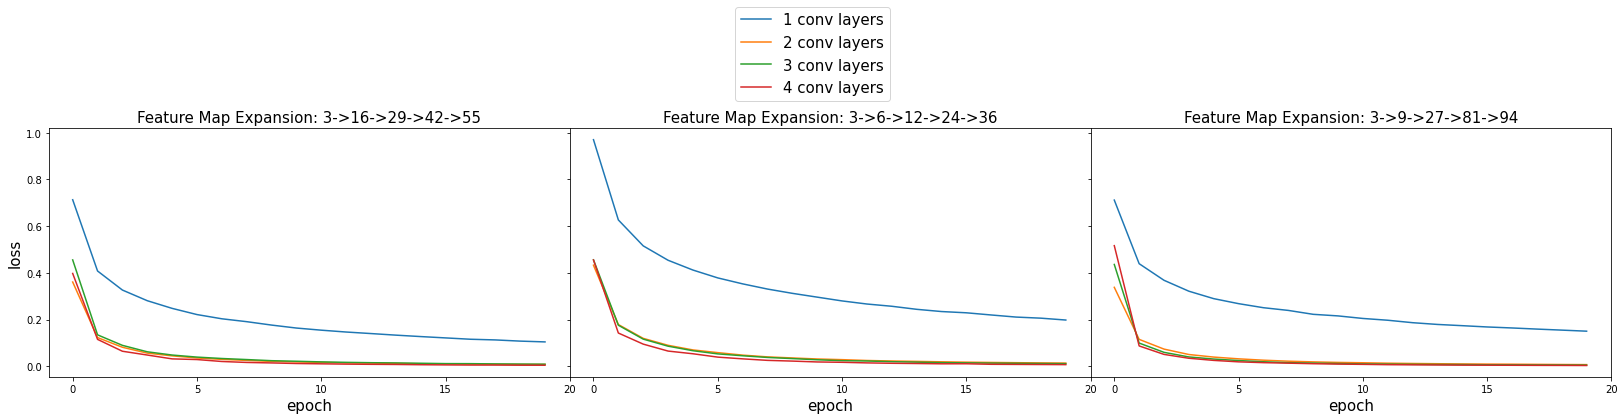

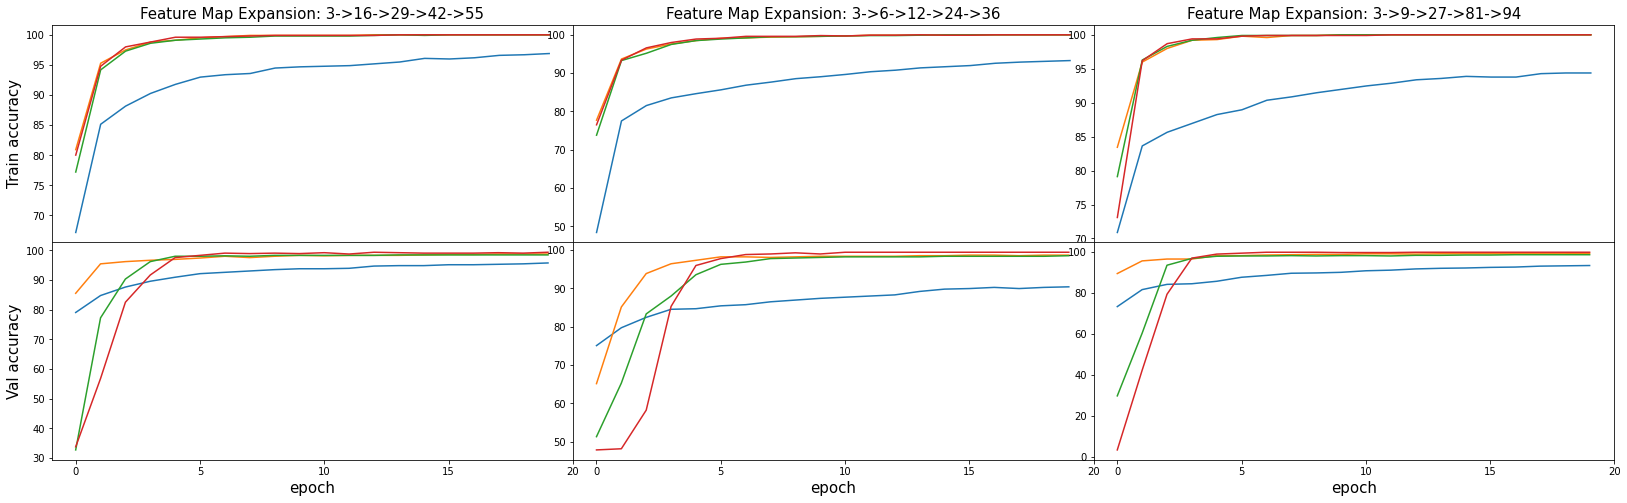

In [60]:
def str_conv_seq(expr, n_lay):
    prior = CHANNELS_D
    conv_seq = str(prior)
    total = 0
    for i in range(n_lay + 1):
        prior = expr(prior)
        total += prior
        conv_seq += f"->{str(prior)}"
    conv_seq
    return conv_seq, total

def plot_losses(runs):
    fig, axs = plt.subplots(1, len(expansions), figsize=(28,6),
        gridspec_kw={'wspace': 0}, sharey=True)

    axs[0].set_ylabel("loss", fontsize=15)
    for (n_lay, expr, n_params, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq, _ = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]
        axs[c].set_title(
            "Feature Map Expansion: " + conv_seq, fontsize=15
        )
        if c == len(expansions) - 1:
            axs[c].plot(
                train_info[0],
                train_info[1],
                label=f"{n_lay + 1} conv layers"
            )    
        else:
            axs[c].plot(train_info[0], train_info[1])

    for ax in axs:
        ax.set_xlabel("epoch", fontsize=15)
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels, fontsize=15, loc="upper center")
    fig.subplots_adjust(top=0.7)

def plot_accuracies(runs):
    fig, axs = plt.subplots(2, len(expansions), figsize=(28,8),
        gridspec_kw={'hspace': 0, 'wspace': 0})

    axs[0, 0].set_ylabel('Train accuracy', fontsize=15)
    axs[1, 0].set_ylabel('Val accuracy', fontsize=15)
    for (n_lay, expr, n_params, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq, _ = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]

        if c == len(expansions) - 1:
            axs[0, c].plot(
                train_info[0],
                train_info[2],
                label=f"{n_lay + 1} conv layers"
            ) 
        else:
            axs[0, c].plot(train_info[0], train_info[2])
        
        axs[0, c].set_title(
            "Feature Map Expansion: " + conv_seq, fontsize=15
        )
        axs[1, c].plot(train_info[0], train_info[3])

    for ax in axs[1, :]:
        ax.set_xlabel("epoch", fontsize=15)
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))
  
plot_losses(runs)
plot_accuracies(runs)

In [61]:
def show_final_acc(runs):
    convs = []
    for (n_lay, expr, _, epoch_data) in runs:
        conv_seq, total = str_conv_seq(expr, n_lay)
        conv_seq += f" FM total: {total}"
        convs.append((f"{epoch_data[-1][-1]}%", conv_seq))
    df = pd.Series(*zip(*convs))
    print("accuracies on validation set")
    return df
        
show_final_acc(runs)

accuracies on validation set


3->16 FM total: 16                 95.789%
3->6 FM total: 6                   90.376%
3->9 FM total: 9                   93.233%
3->16->29 FM total: 45             98.797%
3->6->12 FM total: 18              98.647%
3->9->27 FM total: 36              99.098%
3->16->29->42 FM total: 87         98.496%
3->6->12->24 FM total: 42          98.496%
3->9->27->81 FM total: 117         98.496%
3->16->29->42->55 FM total: 142    99.398%
3->6->12->24->36 FM total: 78      99.398%
3->9->27->81->94 FM total: 211     99.699%
dtype: object

### **What I learned**
Expanding the number of feature maps at each conv layer doesn't seem to have any meaningful influence on the performance. It does appear to perform better the deeper the network gets, the last three runs with four conv layers all performed > 99.0%. I was satisfied with the results, with the best conv net having a score of **99.699%** correct.

I also tried implementing a few popular ConvNet architectures that interested me for fun.

More methods of evaluating the performance of a model

### **VGGNet implementation**

<a href="https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> 

![vgg_arch.png](./imgs/vgg_arch.png)

**Notes**
- Conv layers use 3x3 kernel with the exception of C
- C uses 1x1 kernel at the end of the last three sections 
- Padding used on convolutions to maintain dimensionality of input
- Maxpool between each section of conv layers uses 2x2 for kernel and stride
- Maxpool is followed by ReLU

The original VGG didn't include batchnorm operations in the model, so that is something I included. Another thing to note is the image size they used. They used 224x224, however, my images will remain 256x256. I will not be experimenting with A-LRN, as the paper concluded that it did not improve performance and only increased memory usage and computation time. I didn't include softmax on the output because I'm using cross entropy loss as my loss function.

In [65]:
class VGG(nn.Module):
    def __init__(self, net_config=None):
        super().__init__()
        self.configs = {         # not including A-LRN for convenience
            'A': [1, 1, 2, 2, 2],
            'B': [2, 2, 2, 2, 2],
            'C': [2, 2, 3, 3, 3],
            'D': [2, 2, 3, 3, 3],
            'E': [2, 2, 4, 4, 4]
        }
        if net_config:
            self.fcl, self.net = self._gen_layers(net_config)
            self.classifier = self._classifier()

    def _gen_layers(self, net_config):
        layers = []
        num_layers = self.configs[net_config]
        in_channels, out_channels = CHANNELS_D, 64

        for i, n in enumerate(num_layers):
            for j in range(1, n + 1):
                c_trans = net_config == "C" and j == n and out_channels >= 256
                (kernel, pad) = (1, 0) if c_trans else (3, 1)
                layers.append(nn.Conv2d(
                        in_channels, out_channels, kernel, padding=pad
                    )
                )
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                in_channels = out_channels
            layers.append(nn.MaxPool2d(2, 2))
            if out_channels < 512:
                out_channels *= 2
        fcl = ((IMG_SIZE // (2 ** 5)) ** 2) * in_channels

        return fcl, nn.Sequential(*layers)

    def _classifier(self):
        layers = []
        layers += [
            nn.Flatten(1),
            nn.Linear(self.fcl, 4096), nn.ReLU(),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Linear(4096, NUM_CLASSES)
        ]

        return nn.Sequential(*layers)
        
    def forward(self, x):
        return self.classifier(self.net(x))

The model is actually very basic and structured similarly to how I designed my vanilla CNN architecture. The main distinction being the number of conv layers used. Also, a conv layer will expand the number of feature maps less frequently and only by a factor of 2 starting from 64.

In [ ]:
runs_vgg = []
batch_size = 16
num_epochs = 30
lr = 1e-3

for (vgg_arch, layers) in VGG().configs.items():
    model = VGG(vgg_arch).to(device)
    epoch_data = train(
        model,
        train_data,
        val_data,
        batch_size,
        num_epochs,
        lr,
        class_weights
    )
    print("evaluating...")
    model.eval()
    _, accuracy = eval(model, val_data)
    runs_vgg.append((
        "VGG-" + str(np.sum(layers) + 3) + vgg_arch,
        n_params,
        epoch_data
    ))
    del model

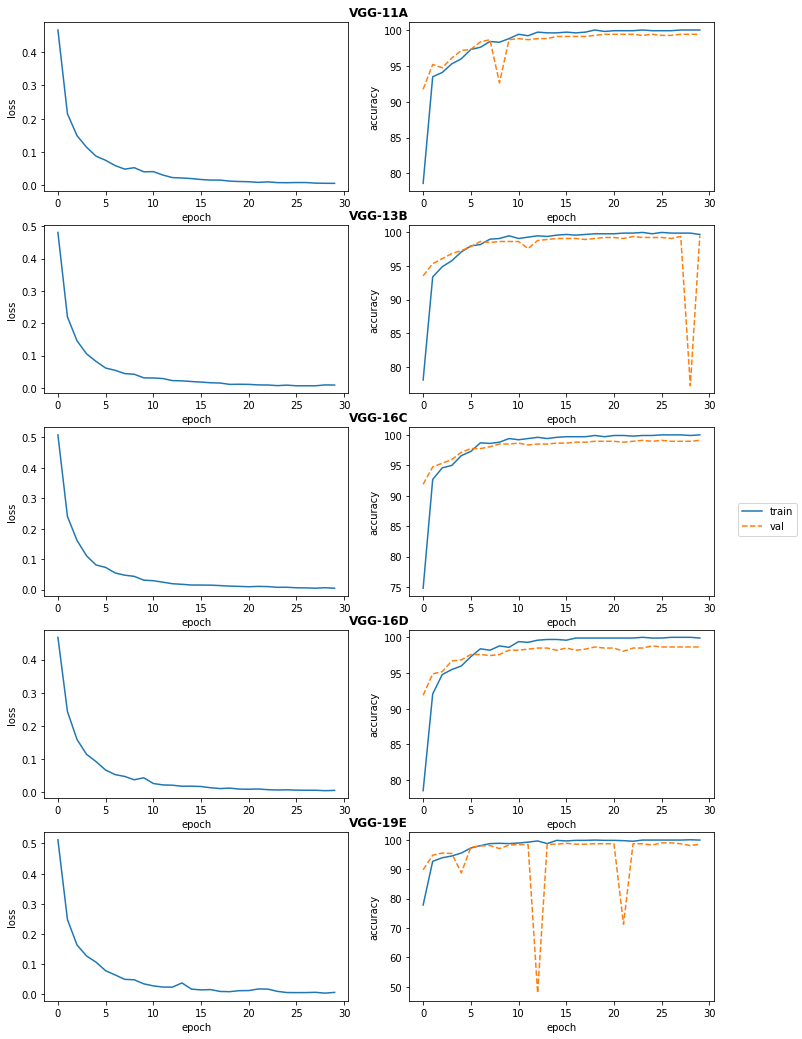

In [76]:
def subtitle(fig, grid, title):
    row = fig.add_subplot(grid)
    row.set_title(f'{title}', fontweight='semibold')
    row.set_frame_on(False)
    row.axis('off')

def plot_runs(runs):
    fig, axs = plt.subplots(len(runs), 2, figsize=(12,18))
    grid = plt.GridSpec(len(runs), 2)

    for i, (label, accuracy, epoch_data) in enumerate(runs):
        train_info = [*zip(*epoch_data)]
        axs[i, 0].set(ylabel="loss")
        axs[i, 1].set(ylabel="accuracy")
        axs[i, 0].plot(train_info[0], train_info[1], label=label)
        axs[i, 1].plot(train_info[0], train_info[2], label="train")
        axs[i, 1].plot(
            train_info[0], train_info[3], linestyle="dashed", label="val"
        )
        subtitle(fig, grid[i, ::], label)

    for ax in axs:
        ax[0].set(ylabel="loss")
        ax[1].set(ylabel="accuracy")
        ax[0].set(xlabel="epoch")
        ax[1].set(xlabel="epoch")

    lines_labels = [ax.get_legend_handles_labels() for ax in axs[0][1:]]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels, loc='center right')
    plt.show()

plot_runs(runs_vgg)

Looking at the accuracy for the validation set, there are massive dips in some of the models. If you look closely, you can correspond these dips to an increase on the loss curve at the same epoch, which would explain the drop in accuracy.

In [139]:
def show_final_acc(runs):
    convs = []
    for (arch, n_params, epoch_data) in runs:
        convs.append((f"{epoch_data[-1][-1]}%", arch))
    df = pd.Series(*zip(*convs))
    print("accuracies on validation set")
    return df
        
show_final_acc(runs_vgg)

accuracies on validation set


VGG-11A    99.398%
VGG-13B    99.549%
VGG-16C    99.098%
VGG-16D    98.647%
VGG-19E    98.496%
dtype: object

### **GoogLeNet implementation**

<a href="https://arxiv.org/abs/1409.4842.pdf">Going Deeper with Convolutions</a> 

**Architecture**

![google_arch.png](./imgs/google_arch.png)

The changes I made from the original VGG net architecture can pratically be applied here. Original GoogLeNet didn't use batchnorms, it used softmax, and trained on 224x224 images.

Same sequences of operations following a convolution as the other networks, but this time I made it into its own class to be applied repeatedly throughout the network.

In [104]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

**Inception block**

![inception_block.png](./imgs/inception_block.png)

This block is responsible for deciding which kernel sizes contribute the most on a given input in the network. Since using 3x3 and 5x5 filters can be computationally expensive, they apply 1x1 filters before them to reduce the number of input features for those conv layers.

In [105]:
class Inception(nn.Module):
    def __init__(self, in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool):
        super().__init__()
        self.inc_block = self._gen_branches(
            in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool
        )

    def _gen_branches(self, in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool):
        b1 = nn.Sequential(Conv(in_channels, _1x1, kernel_size=1).to(device))
        b2 = nn.Sequential(
            Conv(in_channels, _3x3r, kernel_size=1).to(device),
            Conv(_3x3r, _3x3, kernel_size=3, padding=1).to(device)
        )
        b3 = nn.Sequential(
            Conv(in_channels, _5x5r, kernel_size=1).to(device),
            Conv(_5x5r, _5x5, kernel_size=5, padding=2).to(device)
        )
        b4 = nn.Sequential(
            nn.MaxPool2d(3, 1, 1),
            Conv(in_channels, pool, kernel_size=1).to(device)
        )

        return [b1, b2, b3, b4]

    def forward(self, x):
        return torch.cat([b(x) for b in self.inc_block], dim=1)

In [119]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = self._gen_layers()
        self.classifier = self._classifier()

    def _gen_layers(self):
        layers = [
            Conv(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, 1),
            Conv(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(3, 2, 1),
            Inception(192, 64, 96, 128, 16, 32, 32),
            Inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1),
            Inception(480, 192, 96, 208, 16, 48, 64),
            Inception(512, 160, 112, 224, 24, 64, 64),
            Inception(512, 128, 128, 256, 24, 64, 64),
            Inception(512, 112, 144, 288, 32, 64, 64),
            Inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, 1),
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 192, 384, 48, 128, 128),
        ]

        return nn.Sequential(*layers)

    def _classifier(self):
        feature_map_dim = IMG_SIZE // (2 ** 5)
        layers = [
            nn.AvgPool2d(feature_map_dim, 1),
            nn.Flatten(1),
            nn.Dropout(0.4),
            nn.Linear(1024, NUM_CLASSES)
        ]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = self.classifier(x)
        
        return x

I constructed the layers for the network using the same values in the same order from the table above.

In [ ]:
runs_google = []
batch_size = 64
num_epochs = 100
lr = 1e-3

model = GoogLeNet().to(device)
epoch_data = train(
        model,
        train_data,
        val_data,
        batch_size,
        num_epochs,
        lr,
        class_weights
    )
print("evaluating...")
n_params = count_params(model)
runs_google.append(("GoogLeNet", n_params, epoch_data))
del model

GoogLeNet accuracy: 99.000


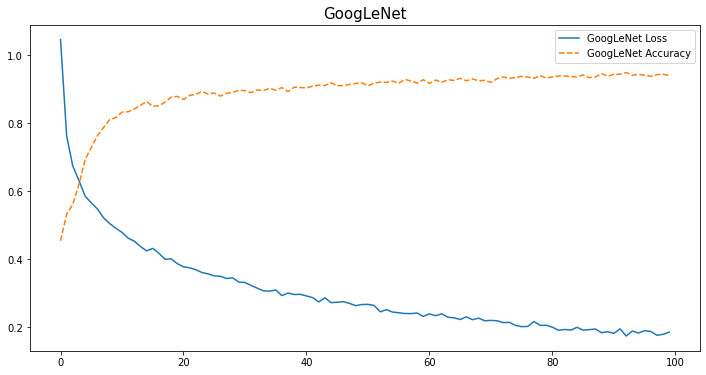

In [138]:
train_info = [*zip(*runs_google[0][2])]
acc = np.array(train_info[2]) / 100
plt.figure(figsize=(12,6))
plt.title("GoogLeNet", fontsize=15)
plt.plot(train_info[0], train_info[1], label="GoogLeNet Loss")
plt.plot(train_info[0], acc, label="GoogLeNet Accuracy", linestyle="dashed")
plt.legend()

print(f"GoogLeNet accuracy: {train_info[0][-1]:.3f}")